In [1]:
import numpy as np
import pandas as pd
import joblib

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading our inputs for training**

In [3]:
df_inputs = torch.load('tensors/df_inputs.pt')
df_inputs

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0007, 0.0021, 0.0014,  ..., 0.0008, 0.0012, 0.0011],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

**B. Loading our targets for training**

In [4]:
df_targets = torch.load('tensors/df_targets.pt')
df_targets

tensor([1, 2, 1,  ..., 0, 1, 1])

**C. Loading our inputs for testing**

In [5]:
X_test_vec = torch.load('tensors/X_test_vec.pt')
X_test_vec

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

**D. Loading our targets for testing**

In [6]:
y_test1 = torch.load('tensors/y_test.pt')
y_test1

tensor([1, 2, 2,  ..., 1, 2, 1])

**E. Train-test Split**

In [7]:
X_train, X_test, y_train, y_test2 = train_test_split(df_inputs, df_targets, test_size=0.2, random_state=21, stratify=df_targets)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 50312
# Test data samples: 12579


In [8]:
X_train.shape

torch.Size([50312, 5000])

In [9]:
X_test.shape

torch.Size([12579, 5000])

In [10]:
y_train.shape

torch.Size([50312])

In [11]:
y_test2.shape

torch.Size([12579])

**F. Creating our Neural Network Architecture**

In [12]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class BalancedNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y

In [13]:
# Create an instance of the model and send it to target device
model_2 = BalancedNeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_2

BalancedNeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

In [14]:
learning_rate_2 = 0.0001
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate_2)
batch_size = 128

In [15]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

**G. Training the Network**

In [16]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset_2 = MyCustomDataset(x=X_train, y=y_train)

train_loader = DataLoader(
    custom_dataset_2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 300
losses_2 = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_2,
        optimizer_2,
        loss_fn_2,
        batch_size
    )
    
    losses_2.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_2.state_dict() }
torch.save(state, "./torch_models/model_2.pth")

Epoch: 0


100%|██████████| 394/394 [00:03<00:00, 101.71it/s, loss=1.08]


Ave Loss: 1.082009098251459
Epoch: 1


100%|██████████| 394/394 [00:03<00:00, 126.73it/s, loss=1.03] 


Ave Loss: 1.018640665989842
Epoch: 2


100%|██████████| 394/394 [00:03<00:00, 128.09it/s, loss=0.987]


Ave Loss: 0.9345667483237794
Epoch: 3


100%|██████████| 394/394 [00:03<00:00, 126.27it/s, loss=0.941]


Ave Loss: 0.8600508956437184
Epoch: 4


100%|██████████| 394/394 [00:02<00:00, 131.95it/s, loss=0.898]


Ave Loss: 0.8022994448993411
Epoch: 5


100%|██████████| 394/394 [00:02<00:00, 132.44it/s, loss=0.855]


Ave Loss: 0.7586925724133622
Epoch: 6


100%|██████████| 394/394 [00:02<00:00, 149.29it/s, loss=0.812]


Ave Loss: 0.7246534993805861
Epoch: 7


100%|██████████| 394/394 [00:02<00:00, 145.36it/s, loss=0.77] 


Ave Loss: 0.697427079762299
Epoch: 8


100%|██████████| 394/394 [00:02<00:00, 146.68it/s, loss=0.73] 


Ave Loss: 0.6752129236453681
Epoch: 9


100%|██████████| 394/394 [00:03<00:00, 122.74it/s, loss=0.691]


Ave Loss: 0.6567735973045911
Epoch: 10


100%|██████████| 394/394 [00:02<00:00, 134.15it/s, loss=0.654]


Ave Loss: 0.6412302317655632
Epoch: 11


100%|██████████| 394/394 [00:02<00:00, 140.66it/s, loss=0.619]


Ave Loss: 0.6279421578809089
Epoch: 12


100%|██████████| 394/394 [00:02<00:00, 140.91it/s, loss=0.587]


Ave Loss: 0.6164332934593791
Epoch: 13


100%|██████████| 394/394 [00:02<00:00, 146.37it/s, loss=0.556]


Ave Loss: 0.6063510462414795
Epoch: 14


100%|██████████| 394/394 [00:02<00:00, 145.84it/s, loss=0.528]


Ave Loss: 0.597419674475181
Epoch: 15


100%|██████████| 394/394 [00:02<00:00, 146.51it/s, loss=0.501]


Ave Loss: 0.5894347545761748
Epoch: 16


100%|██████████| 394/394 [00:02<00:00, 140.31it/s, loss=0.476]


Ave Loss: 0.5822367086477086
Epoch: 17


100%|██████████| 394/394 [00:02<00:00, 141.52it/s, loss=0.453]


Ave Loss: 0.5756943272001247
Epoch: 18


100%|██████████| 394/394 [00:02<00:00, 140.64it/s, loss=0.431]


Ave Loss: 0.5697043330082433
Epoch: 19


100%|██████████| 394/394 [00:02<00:00, 144.87it/s, loss=0.41] 


Ave Loss: 0.5641883846164355
Epoch: 20


100%|██████████| 394/394 [00:02<00:00, 143.31it/s, loss=0.391]


Ave Loss: 0.5590745541196184
Epoch: 21


100%|██████████| 394/394 [00:02<00:00, 138.37it/s, loss=0.373]


Ave Loss: 0.5543115729759187
Epoch: 22


100%|██████████| 394/394 [00:02<00:00, 142.02it/s, loss=0.356]


Ave Loss: 0.5498570590303634
Epoch: 23


100%|██████████| 394/394 [00:02<00:00, 143.80it/s, loss=0.34] 


Ave Loss: 0.5456712355619759
Epoch: 24


100%|██████████| 394/394 [00:02<00:00, 144.13it/s, loss=0.326]


Ave Loss: 0.5417252998364154
Epoch: 25


100%|██████████| 394/394 [00:02<00:00, 144.93it/s, loss=0.312]


Ave Loss: 0.5379931463051568
Epoch: 26


100%|██████████| 394/394 [00:03<00:00, 109.48it/s, loss=0.299]


Ave Loss: 0.5344520750535926
Epoch: 27


100%|██████████| 394/394 [00:02<00:00, 143.79it/s, loss=0.287]


Ave Loss: 0.531083645856925
Epoch: 28


100%|██████████| 394/394 [00:02<00:00, 136.56it/s, loss=0.276]


Ave Loss: 0.5278690460369672
Epoch: 29


100%|██████████| 394/394 [00:02<00:00, 142.94it/s, loss=0.266]


Ave Loss: 0.524793619810022
Epoch: 30


100%|██████████| 394/394 [00:02<00:00, 144.12it/s, loss=0.256]


Ave Loss: 0.5218468994507329
Epoch: 31


100%|██████████| 394/394 [00:02<00:00, 140.68it/s, loss=0.247]


Ave Loss: 0.5190165839748939
Epoch: 32


100%|██████████| 394/394 [00:02<00:00, 143.24it/s, loss=0.239]


Ave Loss: 0.516296368186849
Epoch: 33


100%|██████████| 394/394 [00:02<00:00, 149.40it/s, loss=0.231]


Ave Loss: 0.513676034050242
Epoch: 34


100%|██████████| 394/394 [00:02<00:00, 148.22it/s, loss=0.224]


Ave Loss: 0.5111480979296157
Epoch: 35


100%|██████████| 394/394 [00:02<00:00, 143.93it/s, loss=0.217]


Ave Loss: 0.5087038407168413
Epoch: 36


100%|██████████| 394/394 [00:02<00:00, 141.64it/s, loss=0.211]


Ave Loss: 0.5063420023561129
Epoch: 37


100%|██████████| 394/394 [00:02<00:00, 135.65it/s, loss=0.205]


Ave Loss: 0.504050331823717
Epoch: 38


100%|██████████| 394/394 [00:02<00:00, 147.64it/s, loss=0.2]  


Ave Loss: 0.5018289994996816
Epoch: 39


100%|██████████| 394/394 [00:02<00:00, 151.89it/s, loss=0.194]


Ave Loss: 0.4996717088869986
Epoch: 40


100%|██████████| 394/394 [00:02<00:00, 138.61it/s, loss=0.19] 


Ave Loss: 0.4975747645355118
Epoch: 41


100%|██████████| 394/394 [00:02<00:00, 137.37it/s, loss=0.186]


Ave Loss: 0.4955334865351014
Epoch: 42


100%|██████████| 394/394 [00:02<00:00, 140.35it/s, loss=0.181]


Ave Loss: 0.49354742187533884
Epoch: 43


100%|██████████| 394/394 [00:02<00:00, 141.48it/s, loss=0.178]


Ave Loss: 0.4916107543001925
Epoch: 44


100%|██████████| 394/394 [00:02<00:00, 142.21it/s, loss=0.174]


Ave Loss: 0.4897193932896338
Epoch: 45


100%|██████████| 394/394 [00:02<00:00, 137.13it/s, loss=0.171]


Ave Loss: 0.48787209520182634
Epoch: 46


100%|██████████| 394/394 [00:02<00:00, 136.68it/s, loss=0.168]


Ave Loss: 0.48606785817951115
Epoch: 47


100%|██████████| 394/394 [00:02<00:00, 142.45it/s, loss=0.165]


Ave Loss: 0.4842998384294776
Epoch: 48


100%|██████████| 394/394 [00:02<00:00, 149.21it/s, loss=0.163]


Ave Loss: 0.4825687978775973
Epoch: 49


100%|██████████| 394/394 [00:02<00:00, 134.97it/s, loss=0.16] 


Ave Loss: 0.4808725336481472
Epoch: 50


100%|██████████| 394/394 [00:02<00:00, 135.22it/s, loss=0.158]


Ave Loss: 0.4792104874014249
Epoch: 51


100%|██████████| 394/394 [00:02<00:00, 134.30it/s, loss=0.155]


Ave Loss: 0.4775806527754982
Epoch: 52


100%|██████████| 394/394 [00:02<00:00, 140.50it/s, loss=0.153]


Ave Loss: 0.47598002945559886
Epoch: 53


100%|██████████| 394/394 [00:02<00:00, 143.51it/s, loss=0.151]


Ave Loss: 0.47441093933763845
Epoch: 54


100%|██████████| 394/394 [00:02<00:00, 149.88it/s, loss=0.149]


Ave Loss: 0.47286223937866045
Epoch: 55


100%|██████████| 394/394 [00:02<00:00, 143.93it/s, loss=0.148]


Ave Loss: 0.4713456809974564
Epoch: 56


100%|██████████| 394/394 [00:02<00:00, 143.41it/s, loss=0.146]


Ave Loss: 0.4698496774822322
Epoch: 57


100%|██████████| 394/394 [00:02<00:00, 145.12it/s, loss=0.145]


Ave Loss: 0.46838087448613897
Epoch: 58


100%|██████████| 394/394 [00:02<00:00, 146.32it/s, loss=0.143]


Ave Loss: 0.4669302034801638
Epoch: 59


100%|██████████| 394/394 [00:02<00:00, 145.91it/s, loss=0.142]


Ave Loss: 0.46550456786216216
Epoch: 60


100%|██████████| 394/394 [00:02<00:00, 146.91it/s, loss=0.14] 


Ave Loss: 0.46409822641139103
Epoch: 61


100%|██████████| 394/394 [00:02<00:00, 146.90it/s, loss=0.139]


Ave Loss: 0.46271240979735623
Epoch: 62


100%|██████████| 394/394 [00:02<00:00, 144.90it/s, loss=0.138]


Ave Loss: 0.4613463686883147
Epoch: 63


100%|██████████| 394/394 [00:02<00:00, 140.68it/s, loss=0.136]


Ave Loss: 0.4599929470852547
Epoch: 64


100%|██████████| 394/394 [00:02<00:00, 149.42it/s, loss=0.136]


Ave Loss: 0.45865996624461286
Epoch: 65


100%|██████████| 394/394 [00:02<00:00, 136.03it/s, loss=0.134]


Ave Loss: 0.45734099332753775
Epoch: 66


100%|██████████| 394/394 [00:02<00:00, 145.38it/s, loss=0.133]


Ave Loss: 0.4560371066637451
Epoch: 67


100%|██████████| 394/394 [00:02<00:00, 139.14it/s, loss=0.132]


Ave Loss: 0.4547478248398316
Epoch: 68


100%|██████████| 394/394 [00:02<00:00, 141.23it/s, loss=0.131]


Ave Loss: 0.4534715432957344
Epoch: 69


100%|██████████| 394/394 [00:02<00:00, 144.03it/s, loss=0.13] 


Ave Loss: 0.4522057744830393
Epoch: 70


100%|██████████| 394/394 [00:02<00:00, 147.89it/s, loss=0.129]


Ave Loss: 0.45095690581853015
Epoch: 71


100%|██████████| 394/394 [00:02<00:00, 139.97it/s, loss=0.128]


Ave Loss: 0.4497169998999174
Epoch: 72


100%|██████████| 394/394 [00:02<00:00, 137.65it/s, loss=0.128]


Ave Loss: 0.44848937541246414
Epoch: 73


100%|██████████| 394/394 [00:02<00:00, 140.60it/s, loss=0.127]


Ave Loss: 0.4472754337839064
Epoch: 74


100%|██████████| 394/394 [00:02<00:00, 134.64it/s, loss=0.126]


Ave Loss: 0.4460686109014574
Epoch: 75


100%|██████████| 394/394 [00:02<00:00, 141.11it/s, loss=0.125]


Ave Loss: 0.44487065712207463
Epoch: 76


100%|██████████| 394/394 [00:02<00:00, 137.95it/s, loss=0.125]


Ave Loss: 0.44368046336821493
Epoch: 77


100%|██████████| 394/394 [00:02<00:00, 142.69it/s, loss=0.124]


Ave Loss: 0.44250719491297824
Epoch: 78


100%|██████████| 394/394 [00:02<00:00, 135.82it/s, loss=0.123]


Ave Loss: 0.4413348234773892
Epoch: 79


100%|██████████| 394/394 [00:02<00:00, 133.89it/s, loss=0.123]


Ave Loss: 0.440169716320062
Epoch: 80


100%|██████████| 394/394 [00:02<00:00, 140.69it/s, loss=0.122]


Ave Loss: 0.4390148860095116
Epoch: 81


100%|██████████| 394/394 [00:02<00:00, 142.31it/s, loss=0.121]


Ave Loss: 0.4378669406783762
Epoch: 82


100%|██████████| 394/394 [00:02<00:00, 143.32it/s, loss=0.121]


Ave Loss: 0.4367265247829675
Epoch: 83


100%|██████████| 394/394 [00:02<00:00, 140.12it/s, loss=0.12] 


Ave Loss: 0.4355946158243315
Epoch: 84


100%|██████████| 394/394 [00:02<00:00, 139.78it/s, loss=0.119]


Ave Loss: 0.43446649601541193
Epoch: 85


100%|██████████| 394/394 [00:02<00:00, 142.59it/s, loss=0.119]


Ave Loss: 0.43334515648066696
Epoch: 86


100%|██████████| 394/394 [00:02<00:00, 146.03it/s, loss=0.118]


Ave Loss: 0.4322303640207058
Epoch: 87


100%|██████████| 394/394 [00:02<00:00, 141.17it/s, loss=0.117]


Ave Loss: 0.4311199377711654
Epoch: 88


100%|██████████| 394/394 [00:02<00:00, 139.92it/s, loss=0.117]


Ave Loss: 0.43001497714652626
Epoch: 89


100%|██████████| 394/394 [00:02<00:00, 141.03it/s, loss=0.116]


Ave Loss: 0.42891448157541645
Epoch: 90


100%|██████████| 394/394 [00:02<00:00, 148.85it/s, loss=0.116]


Ave Loss: 0.4278190500542597
Epoch: 91


100%|██████████| 394/394 [00:02<00:00, 141.64it/s, loss=0.115]


Ave Loss: 0.4267274458812276
Epoch: 92


100%|██████████| 394/394 [00:02<00:00, 136.09it/s, loss=0.115]


Ave Loss: 0.42563892526523717
Epoch: 93


100%|██████████| 394/394 [00:02<00:00, 142.65it/s, loss=0.114]


Ave Loss: 0.42455171852320583
Epoch: 94


100%|██████████| 394/394 [00:02<00:00, 143.34it/s, loss=0.114]


Ave Loss: 0.42347264596199624
Epoch: 95


100%|██████████| 394/394 [00:02<00:00, 140.83it/s, loss=0.113]


Ave Loss: 0.4223920360283198
Epoch: 96


100%|██████████| 394/394 [00:02<00:00, 132.43it/s, loss=0.113]


Ave Loss: 0.42131480782618985
Epoch: 97


100%|██████████| 394/394 [00:02<00:00, 143.19it/s, loss=0.112]


Ave Loss: 0.4202395569400739
Epoch: 98


100%|██████████| 394/394 [00:02<00:00, 142.17it/s, loss=0.112]


Ave Loss: 0.41916524826875196
Epoch: 99


100%|██████████| 394/394 [00:02<00:00, 136.27it/s, loss=0.111]


Ave Loss: 0.41809441427213284
Epoch: 100


100%|██████████| 394/394 [00:02<00:00, 134.47it/s, loss=0.111]


Ave Loss: 0.4170271819693788
Epoch: 101


100%|██████████| 394/394 [00:02<00:00, 136.63it/s, loss=0.11] 


Ave Loss: 0.41596195326768204
Epoch: 102


100%|██████████| 394/394 [00:02<00:00, 137.43it/s, loss=0.11] 


Ave Loss: 0.4148993535997904
Epoch: 103


100%|██████████| 394/394 [00:02<00:00, 140.91it/s, loss=0.109]


Ave Loss: 0.41384071003891487
Epoch: 104


100%|██████████| 394/394 [00:02<00:00, 139.42it/s, loss=0.109]


Ave Loss: 0.41278327615733074
Epoch: 105


100%|██████████| 394/394 [00:02<00:00, 134.24it/s, loss=0.108]


Ave Loss: 0.4117207049491442
Epoch: 106


100%|██████████| 394/394 [00:02<00:00, 140.47it/s, loss=0.108]


Ave Loss: 0.41066347911651363
Epoch: 107


100%|██████████| 394/394 [00:02<00:00, 138.11it/s, loss=0.107]


Ave Loss: 0.4096050631198181
Epoch: 108


100%|██████████| 394/394 [00:02<00:00, 140.67it/s, loss=0.107]


Ave Loss: 0.40854637502564994
Epoch: 109


100%|██████████| 394/394 [00:02<00:00, 139.49it/s, loss=0.107]


Ave Loss: 0.4074857302274801
Epoch: 110


100%|██████████| 394/394 [00:02<00:00, 138.51it/s, loss=0.106]


Ave Loss: 0.40642894206918434
Epoch: 111


100%|██████████| 394/394 [00:02<00:00, 132.25it/s, loss=0.106]


Ave Loss: 0.40537250102474
Epoch: 112


100%|██████████| 394/394 [00:02<00:00, 136.21it/s, loss=0.105]


Ave Loss: 0.4043184413863015
Epoch: 113


100%|██████████| 394/394 [00:02<00:00, 140.59it/s, loss=0.105]


Ave Loss: 0.40326355915838086
Epoch: 114


100%|██████████| 394/394 [00:02<00:00, 146.88it/s, loss=0.104]


Ave Loss: 0.40220582723466275
Epoch: 115


100%|██████████| 394/394 [00:02<00:00, 133.33it/s, loss=0.104]


Ave Loss: 0.4011529286954609
Epoch: 116


100%|██████████| 394/394 [00:02<00:00, 136.68it/s, loss=0.103]


Ave Loss: 0.4000985585153103
Epoch: 117


100%|██████████| 394/394 [00:02<00:00, 134.86it/s, loss=0.103]


Ave Loss: 0.39904382319998016
Epoch: 118


100%|██████████| 394/394 [00:02<00:00, 141.73it/s, loss=0.102]


Ave Loss: 0.3979873213217343
Epoch: 119


100%|██████████| 394/394 [00:02<00:00, 142.46it/s, loss=0.102]


Ave Loss: 0.3969319122016127
Epoch: 120


100%|██████████| 394/394 [00:02<00:00, 142.62it/s, loss=0.101]


Ave Loss: 0.3958745897572658
Epoch: 121


100%|██████████| 394/394 [00:02<00:00, 138.31it/s, loss=0.101]


Ave Loss: 0.39481476444732116
Epoch: 122


100%|██████████| 394/394 [00:02<00:00, 151.23it/s, loss=0.101]


Ave Loss: 0.39375742490824106
Epoch: 123


100%|██████████| 394/394 [00:02<00:00, 145.30it/s, loss=0.1]  


Ave Loss: 0.392693656104319
Epoch: 124


100%|██████████| 394/394 [00:02<00:00, 139.70it/s, loss=0.0999]


Ave Loss: 0.3916392641586398
Epoch: 125


100%|██████████| 394/394 [00:02<00:00, 138.06it/s, loss=0.0994]


Ave Loss: 0.39057144670165733
Epoch: 126


100%|██████████| 394/394 [00:02<00:00, 138.68it/s, loss=0.0991]


Ave Loss: 0.38951548120848417
Epoch: 127


100%|██████████| 394/394 [00:02<00:00, 138.10it/s, loss=0.0987]


Ave Loss: 0.38844801929925904
Epoch: 128


100%|██████████| 394/394 [00:02<00:00, 150.36it/s, loss=0.0982]


Ave Loss: 0.3873836549027317
Epoch: 129


100%|██████████| 394/394 [00:02<00:00, 156.04it/s, loss=0.0976]


Ave Loss: 0.38631592539663845
Epoch: 130


100%|██████████| 394/394 [00:02<00:00, 152.67it/s, loss=0.0973]


Ave Loss: 0.3852490011961932
Epoch: 131


100%|██████████| 394/394 [00:02<00:00, 146.10it/s, loss=0.097]


Ave Loss: 0.3841793550944268
Epoch: 132


100%|██████████| 394/394 [00:02<00:00, 139.53it/s, loss=0.0965]


Ave Loss: 0.3831099458227908
Epoch: 133


100%|██████████| 394/394 [00:02<00:00, 138.06it/s, loss=0.0962]


Ave Loss: 0.38203751518944196
Epoch: 134


100%|██████████| 394/394 [00:02<00:00, 144.22it/s, loss=0.0956]


Ave Loss: 0.3809723926112434
Epoch: 135


100%|██████████| 394/394 [00:02<00:00, 153.98it/s, loss=0.0952]


Ave Loss: 0.3798973423235005
Epoch: 136


100%|██████████| 394/394 [00:02<00:00, 152.82it/s, loss=0.0946]


Ave Loss: 0.37882581924272674
Epoch: 137


100%|██████████| 394/394 [00:02<00:00, 150.97it/s, loss=0.0943]


Ave Loss: 0.3777516135180057
Epoch: 138


100%|██████████| 394/394 [00:02<00:00, 148.89it/s, loss=0.0941]


Ave Loss: 0.376673284029295
Epoch: 139


100%|██████████| 394/394 [00:02<00:00, 151.38it/s, loss=0.0939]


Ave Loss: 0.3755967889529497
Epoch: 140


100%|██████████| 394/394 [00:02<00:00, 154.04it/s, loss=0.0934]


Ave Loss: 0.37451894235263017
Epoch: 141


100%|██████████| 394/394 [00:02<00:00, 150.28it/s, loss=0.093]


Ave Loss: 0.37343930880430387
Epoch: 142


100%|██████████| 394/394 [00:02<00:00, 145.79it/s, loss=0.0926]


Ave Loss: 0.3723601061604955
Epoch: 143


100%|██████████| 394/394 [00:02<00:00, 143.73it/s, loss=0.092]


Ave Loss: 0.3712765238233629
Epoch: 144


100%|██████████| 394/394 [00:02<00:00, 150.12it/s, loss=0.0916]


Ave Loss: 0.370193854466005
Epoch: 145


100%|██████████| 394/394 [00:02<00:00, 149.67it/s, loss=0.0915]


Ave Loss: 0.36910534892136676
Epoch: 146


100%|██████████| 394/394 [00:02<00:00, 141.65it/s, loss=0.0911]


Ave Loss: 0.3680237319679732
Epoch: 147


100%|██████████| 394/394 [00:02<00:00, 150.97it/s, loss=0.0908]


Ave Loss: 0.3669333573487507
Epoch: 148


100%|██████████| 394/394 [00:02<00:00, 145.92it/s, loss=0.0902]


Ave Loss: 0.3658386130774687
Epoch: 149


100%|██████████| 394/394 [00:02<00:00, 148.27it/s, loss=0.0899]


Ave Loss: 0.3647516505972383
Epoch: 150


100%|██████████| 394/394 [00:02<00:00, 144.35it/s, loss=0.0895]


Ave Loss: 0.3636564755538091
Epoch: 151


100%|██████████| 394/394 [00:02<00:00, 151.69it/s, loss=0.0892]


Ave Loss: 0.3625648464950813
Epoch: 152


100%|██████████| 394/394 [00:02<00:00, 151.81it/s, loss=0.0889]


Ave Loss: 0.3614724493268783
Epoch: 153


100%|██████████| 394/394 [00:02<00:00, 150.28it/s, loss=0.0885]


Ave Loss: 0.36037338366211974
Epoch: 154


100%|██████████| 394/394 [00:02<00:00, 145.31it/s, loss=0.0881]


Ave Loss: 0.3592798672049179
Epoch: 155


100%|██████████| 394/394 [00:02<00:00, 153.16it/s, loss=0.0881]


Ave Loss: 0.35817684055433663
Epoch: 156


100%|██████████| 394/394 [00:02<00:00, 154.36it/s, loss=0.0876]


Ave Loss: 0.3570758715120669
Epoch: 157


100%|██████████| 394/394 [00:02<00:00, 147.76it/s, loss=0.0871]


Ave Loss: 0.3559770271333341
Epoch: 158


100%|██████████| 394/394 [00:02<00:00, 153.05it/s, loss=0.0869]


Ave Loss: 0.35486735751483645
Epoch: 159


100%|██████████| 394/394 [00:02<00:00, 152.41it/s, loss=0.0866]


Ave Loss: 0.3537656062939748
Epoch: 160


100%|██████████| 394/394 [00:03<00:00, 123.14it/s, loss=0.0863]


Ave Loss: 0.3526567604562958
Epoch: 161


100%|██████████| 394/394 [00:03<00:00, 120.09it/s, loss=0.0859]


Ave Loss: 0.3515416108412186
Epoch: 162


100%|██████████| 394/394 [00:03<00:00, 124.19it/s, loss=0.0855]


Ave Loss: 0.3504306093085236
Epoch: 163


100%|██████████| 394/394 [00:03<00:00, 115.39it/s, loss=0.0853]


Ave Loss: 0.3493156188976039
Epoch: 164


100%|██████████| 394/394 [00:02<00:00, 134.29it/s, loss=0.0851]


Ave Loss: 0.34820147312534644
Epoch: 165


100%|██████████| 394/394 [00:02<00:00, 133.49it/s, loss=0.0847]


Ave Loss: 0.3470861676532
Epoch: 166


100%|██████████| 394/394 [00:02<00:00, 141.08it/s, loss=0.0845]


Ave Loss: 0.34595957237678737
Epoch: 167


100%|██████████| 394/394 [00:02<00:00, 145.18it/s, loss=0.0842]


Ave Loss: 0.34484493936681504
Epoch: 168


100%|██████████| 394/394 [00:02<00:00, 141.19it/s, loss=0.0838]


Ave Loss: 0.3437252203144398
Epoch: 169


100%|██████████| 394/394 [00:02<00:00, 139.47it/s, loss=0.0836]


Ave Loss: 0.34259815317422604
Epoch: 170


100%|██████████| 394/394 [00:02<00:00, 142.42it/s, loss=0.0831]


Ave Loss: 0.34147504874065443
Epoch: 171


100%|██████████| 394/394 [00:02<00:00, 142.31it/s, loss=0.0828]


Ave Loss: 0.3403441332242816
Epoch: 172


100%|██████████| 394/394 [00:02<00:00, 144.87it/s, loss=0.0824]


Ave Loss: 0.33921656144905815
Epoch: 173


100%|██████████| 394/394 [00:02<00:00, 142.50it/s, loss=0.0823]


Ave Loss: 0.33808552250644275
Epoch: 174


100%|██████████| 394/394 [00:02<00:00, 142.23it/s, loss=0.0819]


Ave Loss: 0.33695364872059846
Epoch: 175


100%|██████████| 394/394 [00:02<00:00, 139.01it/s, loss=0.0817]


Ave Loss: 0.33581951771139495
Epoch: 176


100%|██████████| 394/394 [00:02<00:00, 141.05it/s, loss=0.0814]


Ave Loss: 0.33468651145621
Epoch: 177


100%|██████████| 394/394 [00:02<00:00, 141.55it/s, loss=0.081]


Ave Loss: 0.3335518253976621
Epoch: 178


100%|██████████| 394/394 [00:02<00:00, 142.37it/s, loss=0.0808]


Ave Loss: 0.3324154313218775
Epoch: 179


100%|██████████| 394/394 [00:02<00:00, 139.79it/s, loss=0.0804]


Ave Loss: 0.3312776926999467
Epoch: 180


100%|██████████| 394/394 [00:02<00:00, 138.75it/s, loss=0.0803]


Ave Loss: 0.3301429799214232
Epoch: 181


100%|██████████| 394/394 [00:02<00:00, 140.10it/s, loss=0.0798]


Ave Loss: 0.32900101012611754
Epoch: 182


100%|██████████| 394/394 [00:02<00:00, 148.11it/s, loss=0.0796]


Ave Loss: 0.3278590391205652
Epoch: 183


100%|██████████| 394/394 [00:02<00:00, 153.93it/s, loss=0.0791]


Ave Loss: 0.326715076143669
Epoch: 184


100%|██████████| 394/394 [00:02<00:00, 155.20it/s, loss=0.0789]


Ave Loss: 0.3255757861557951
Epoch: 185


100%|██████████| 394/394 [00:02<00:00, 145.60it/s, loss=0.0787]


Ave Loss: 0.3244247021824878
Epoch: 186


100%|██████████| 394/394 [00:02<00:00, 154.33it/s, loss=0.0783]


Ave Loss: 0.3232708259811861
Epoch: 187


100%|██████████| 394/394 [00:02<00:00, 153.05it/s, loss=0.0781]


Ave Loss: 0.32213140252580497
Epoch: 188


100%|██████████| 394/394 [00:02<00:00, 153.19it/s, loss=0.0776]


Ave Loss: 0.3209815914482635
Epoch: 189


100%|██████████| 394/394 [00:02<00:00, 152.71it/s, loss=0.0772]


Ave Loss: 0.3198214334241932
Epoch: 190


100%|██████████| 394/394 [00:02<00:00, 151.46it/s, loss=0.0772]


Ave Loss: 0.31866988248480155
Epoch: 191


100%|██████████| 394/394 [00:02<00:00, 152.89it/s, loss=0.0772]


Ave Loss: 0.3175224142555658
Epoch: 192


100%|██████████| 394/394 [00:02<00:00, 150.05it/s, loss=0.0768]


Ave Loss: 0.3163635250804993
Epoch: 193


100%|██████████| 394/394 [00:02<00:00, 146.96it/s, loss=0.0762]


Ave Loss: 0.31521198936374056
Epoch: 194


100%|██████████| 394/394 [00:02<00:00, 151.82it/s, loss=0.0759]


Ave Loss: 0.31405332168271094
Epoch: 195


100%|██████████| 394/394 [00:02<00:00, 147.26it/s, loss=0.0759]


Ave Loss: 0.31290027238239493
Epoch: 196


100%|██████████| 394/394 [00:03<00:00, 122.55it/s, loss=0.0753]


Ave Loss: 0.3117453899556005
Epoch: 197


100%|██████████| 394/394 [00:03<00:00, 124.55it/s, loss=0.0752]


Ave Loss: 0.3105843437618108
Epoch: 198


100%|██████████| 394/394 [00:02<00:00, 133.70it/s, loss=0.0747]


Ave Loss: 0.3094210224746145
Epoch: 199


100%|██████████| 394/394 [00:03<00:00, 123.66it/s, loss=0.0744]


Ave Loss: 0.30825991590086577
Epoch: 200


100%|██████████| 394/394 [00:03<00:00, 129.18it/s, loss=0.0739]


Ave Loss: 0.3071020688804878
Epoch: 201


100%|██████████| 394/394 [00:02<00:00, 141.25it/s, loss=0.0739]


Ave Loss: 0.3059331794378116
Epoch: 202


100%|██████████| 394/394 [00:02<00:00, 141.73it/s, loss=0.0735]


Ave Loss: 0.30476453142042087
Epoch: 203


100%|██████████| 394/394 [00:02<00:00, 140.94it/s, loss=0.0732]


Ave Loss: 0.3036039579413869
Epoch: 204


100%|██████████| 394/394 [00:02<00:00, 143.60it/s, loss=0.0732]


Ave Loss: 0.3024313002068379
Epoch: 205


100%|██████████| 394/394 [00:02<00:00, 144.87it/s, loss=0.0728]


Ave Loss: 0.3012698200450936
Epoch: 206


100%|██████████| 394/394 [00:02<00:00, 149.26it/s, loss=0.0725]


Ave Loss: 0.30010196804849026
Epoch: 207


100%|██████████| 394/394 [00:02<00:00, 152.20it/s, loss=0.072]


Ave Loss: 0.29893221494358807
Epoch: 208


100%|██████████| 394/394 [00:02<00:00, 152.67it/s, loss=0.0716]


Ave Loss: 0.2977600043762456
Epoch: 209


100%|██████████| 394/394 [00:03<00:00, 130.07it/s, loss=0.0713]


Ave Loss: 0.29658741628760615
Epoch: 210


100%|██████████| 394/394 [00:03<00:00, 101.30it/s, loss=0.0712]


Ave Loss: 0.2954192622588371
Epoch: 211


100%|██████████| 394/394 [00:02<00:00, 147.14it/s, loss=0.0712]


Ave Loss: 0.29424240201862933
Epoch: 212


100%|██████████| 394/394 [00:02<00:00, 145.89it/s, loss=0.0706]


Ave Loss: 0.2930644566221588
Epoch: 213


100%|██████████| 394/394 [00:03<00:00, 124.65it/s, loss=0.0704]


Ave Loss: 0.2918971690164907
Epoch: 214


100%|██████████| 394/394 [00:02<00:00, 147.69it/s, loss=0.07] 


Ave Loss: 0.2907143209867066
Epoch: 215


100%|██████████| 394/394 [00:02<00:00, 144.12it/s, loss=0.0696]


Ave Loss: 0.28954616440507364
Epoch: 216


100%|██████████| 394/394 [00:02<00:00, 151.30it/s, loss=0.0695]


Ave Loss: 0.28836276431374136
Epoch: 217


100%|██████████| 394/394 [00:02<00:00, 149.46it/s, loss=0.0693]


Ave Loss: 0.287193346106764
Epoch: 218


100%|██████████| 394/394 [00:02<00:00, 156.26it/s, loss=0.0689]


Ave Loss: 0.28600539762507843
Epoch: 219


100%|██████████| 394/394 [00:02<00:00, 152.67it/s, loss=0.0687]


Ave Loss: 0.28484115649374003
Epoch: 220


100%|██████████| 394/394 [00:02<00:00, 155.24it/s, loss=0.0685]


Ave Loss: 0.2836620022500227
Epoch: 221


100%|██████████| 394/394 [00:02<00:00, 147.14it/s, loss=0.0682]


Ave Loss: 0.2824742295944751
Epoch: 222


100%|██████████| 394/394 [00:02<00:00, 149.52it/s, loss=0.0679]


Ave Loss: 0.2813043584527098
Epoch: 223


100%|██████████| 394/394 [00:02<00:00, 150.03it/s, loss=0.0676]


Ave Loss: 0.28011623223496573
Epoch: 224


100%|██████████| 394/394 [00:02<00:00, 132.45it/s, loss=0.0674]


Ave Loss: 0.27893811483219794
Epoch: 225


100%|██████████| 394/394 [00:02<00:00, 140.54it/s, loss=0.0671]


Ave Loss: 0.2777604175362793
Epoch: 226


100%|██████████| 394/394 [00:02<00:00, 141.65it/s, loss=0.067]


Ave Loss: 0.27657622872345944
Epoch: 227


100%|██████████| 394/394 [00:02<00:00, 136.97it/s, loss=0.0667]


Ave Loss: 0.2753912461968848
Epoch: 228


100%|██████████| 394/394 [00:02<00:00, 134.80it/s, loss=0.0662]


Ave Loss: 0.2742152530794519
Epoch: 229


100%|██████████| 394/394 [00:02<00:00, 143.02it/s, loss=0.0661]


Ave Loss: 0.273037687700412
Epoch: 230


100%|██████████| 394/394 [00:02<00:00, 143.14it/s, loss=0.0659]


Ave Loss: 0.27185947222984985
Epoch: 231


100%|██████████| 394/394 [00:02<00:00, 141.84it/s, loss=0.066]


Ave Loss: 0.27067449375003727
Epoch: 232


100%|██████████| 394/394 [00:02<00:00, 146.05it/s, loss=0.0655]


Ave Loss: 0.26949590230880655
Epoch: 233


100%|██████████| 394/394 [00:02<00:00, 148.25it/s, loss=0.0655]


Ave Loss: 0.2683190517883918
Epoch: 234


100%|██████████| 394/394 [00:02<00:00, 148.43it/s, loss=0.0653]


Ave Loss: 0.267131966760921
Epoch: 235


100%|██████████| 394/394 [00:02<00:00, 146.67it/s, loss=0.0652]


Ave Loss: 0.2659589685688769
Epoch: 236


100%|██████████| 394/394 [00:02<00:00, 148.90it/s, loss=0.0647]


Ave Loss: 0.26477867381902515
Epoch: 237


100%|██████████| 394/394 [00:02<00:00, 147.50it/s, loss=0.0645]


Ave Loss: 0.26360881566850064
Epoch: 238


100%|██████████| 394/394 [00:02<00:00, 147.47it/s, loss=0.0643]


Ave Loss: 0.2624338638548016
Epoch: 239


100%|██████████| 394/394 [00:02<00:00, 144.12it/s, loss=0.0638]


Ave Loss: 0.26125124244369224
Epoch: 240


100%|██████████| 394/394 [00:02<00:00, 145.79it/s, loss=0.0637]


Ave Loss: 0.2600898081011276
Epoch: 241


100%|██████████| 394/394 [00:02<00:00, 147.77it/s, loss=0.0634]


Ave Loss: 0.25890802705499727
Epoch: 242


100%|██████████| 394/394 [00:02<00:00, 143.83it/s, loss=0.0633]


Ave Loss: 0.25773804370068054
Epoch: 243


100%|██████████| 394/394 [00:02<00:00, 145.91it/s, loss=0.0631]


Ave Loss: 0.25656021030875026
Epoch: 244


100%|██████████| 394/394 [00:02<00:00, 146.82it/s, loss=0.0627]


Ave Loss: 0.25539655973992975
Epoch: 245


100%|██████████| 394/394 [00:02<00:00, 143.06it/s, loss=0.0624]


Ave Loss: 0.2542262439365466
Epoch: 246


100%|██████████| 394/394 [00:02<00:00, 147.75it/s, loss=0.0623]


Ave Loss: 0.25305707375448067
Epoch: 247


100%|██████████| 394/394 [00:02<00:00, 153.35it/s, loss=0.0618]


Ave Loss: 0.25188373594644103
Epoch: 248


100%|██████████| 394/394 [00:02<00:00, 151.10it/s, loss=0.0619]


Ave Loss: 0.25072317649870357
Epoch: 249


100%|██████████| 394/394 [00:02<00:00, 149.78it/s, loss=0.0617]


Ave Loss: 0.24955055948706145
Epoch: 250


100%|██████████| 394/394 [00:02<00:00, 149.10it/s, loss=0.0617]


Ave Loss: 0.2483893132432917
Epoch: 251


100%|██████████| 394/394 [00:02<00:00, 153.13it/s, loss=0.0612]


Ave Loss: 0.2472224834039429
Epoch: 252


100%|██████████| 394/394 [00:02<00:00, 155.59it/s, loss=0.061]


Ave Loss: 0.24605175570069535
Epoch: 253


100%|██████████| 394/394 [00:02<00:00, 152.92it/s, loss=0.0608]


Ave Loss: 0.24489279908274636
Epoch: 254


100%|██████████| 394/394 [00:02<00:00, 149.24it/s, loss=0.0606]


Ave Loss: 0.2437277472658357
Epoch: 255


100%|██████████| 394/394 [00:02<00:00, 152.52it/s, loss=0.0603]


Ave Loss: 0.24256017379614
Epoch: 256


100%|██████████| 394/394 [00:02<00:00, 152.68it/s, loss=0.0603]


Ave Loss: 0.24140756065735056
Epoch: 257


100%|██████████| 394/394 [00:02<00:00, 153.58it/s, loss=0.0602]


Ave Loss: 0.2402452919537646
Epoch: 258


100%|██████████| 394/394 [00:02<00:00, 149.84it/s, loss=0.0598]


Ave Loss: 0.23909205679550086
Epoch: 259


100%|██████████| 394/394 [00:02<00:00, 152.27it/s, loss=0.0597]


Ave Loss: 0.2379237407922442
Epoch: 260


100%|██████████| 394/394 [00:02<00:00, 144.62it/s, loss=0.0595]


Ave Loss: 0.23677778170269154
Epoch: 261


100%|██████████| 394/394 [00:02<00:00, 147.36it/s, loss=0.0593]


Ave Loss: 0.23561072906450875
Epoch: 262


100%|██████████| 394/394 [00:02<00:00, 146.13it/s, loss=0.059]


Ave Loss: 0.23446511832741918
Epoch: 263


100%|██████████| 394/394 [00:02<00:00, 144.75it/s, loss=0.059]


Ave Loss: 0.2333101005799274
Epoch: 264


100%|██████████| 394/394 [00:02<00:00, 140.25it/s, loss=0.0587]


Ave Loss: 0.23215526847291718
Epoch: 265


100%|██████████| 394/394 [00:02<00:00, 143.63it/s, loss=0.0584]


Ave Loss: 0.23101438056242649
Epoch: 266


100%|██████████| 394/394 [00:02<00:00, 143.23it/s, loss=0.0582]


Ave Loss: 0.22985495763079164
Epoch: 267


100%|██████████| 394/394 [00:02<00:00, 142.37it/s, loss=0.0581]


Ave Loss: 0.22872112160974045
Epoch: 268


100%|██████████| 394/394 [00:02<00:00, 141.99it/s, loss=0.058]


Ave Loss: 0.2275713408072739
Epoch: 269


100%|██████████| 394/394 [00:02<00:00, 136.76it/s, loss=0.0575]


Ave Loss: 0.22643040699250808
Epoch: 270


100%|██████████| 394/394 [00:02<00:00, 148.44it/s, loss=0.0576]


Ave Loss: 0.22529651869447703
Epoch: 271


100%|██████████| 394/394 [00:02<00:00, 143.11it/s, loss=0.057]


Ave Loss: 0.22415390894346432
Epoch: 272


100%|██████████| 394/394 [00:02<00:00, 143.42it/s, loss=0.057]


Ave Loss: 0.22301857937411004
Epoch: 273


100%|██████████| 394/394 [00:02<00:00, 141.81it/s, loss=0.0565]


Ave Loss: 0.22188486809355354
Epoch: 274


100%|██████████| 394/394 [00:02<00:00, 145.94it/s, loss=0.0565]


Ave Loss: 0.2207537418429924
Epoch: 275


100%|██████████| 394/394 [00:02<00:00, 139.93it/s, loss=0.0563]


Ave Loss: 0.2196221947480882
Epoch: 276


100%|██████████| 394/394 [00:02<00:00, 135.58it/s, loss=0.0561]


Ave Loss: 0.21849396887240072
Epoch: 277


100%|██████████| 394/394 [00:02<00:00, 136.91it/s, loss=0.0559]


Ave Loss: 0.21736339502376953
Epoch: 278


100%|██████████| 394/394 [00:02<00:00, 132.91it/s, loss=0.0556]


Ave Loss: 0.21624389891205403
Epoch: 279


100%|██████████| 394/394 [00:02<00:00, 138.33it/s, loss=0.0555]


Ave Loss: 0.2151131853366715
Epoch: 280


100%|██████████| 394/394 [00:02<00:00, 147.23it/s, loss=0.0554]


Ave Loss: 0.21399798492905756
Epoch: 281


100%|██████████| 394/394 [00:02<00:00, 148.91it/s, loss=0.0549]


Ave Loss: 0.21287416642163007
Epoch: 282


100%|██████████| 394/394 [00:02<00:00, 142.28it/s, loss=0.0548]


Ave Loss: 0.21176083905026694
Epoch: 283


100%|██████████| 394/394 [00:02<00:00, 140.71it/s, loss=0.0544]


Ave Loss: 0.21064732408122666
Epoch: 284


100%|██████████| 394/394 [00:02<00:00, 142.71it/s, loss=0.0545]


Ave Loss: 0.20952993671074133
Epoch: 285


100%|██████████| 394/394 [00:02<00:00, 146.26it/s, loss=0.054]


Ave Loss: 0.20842430538256762
Epoch: 286


100%|██████████| 394/394 [00:02<00:00, 143.53it/s, loss=0.054]


Ave Loss: 0.20732181753755222
Epoch: 287


100%|██████████| 394/394 [00:02<00:00, 145.39it/s, loss=0.0537]


Ave Loss: 0.20621490796205355
Epoch: 288


100%|██████████| 394/394 [00:02<00:00, 147.42it/s, loss=0.0535]


Ave Loss: 0.20511047428634566
Epoch: 289


100%|██████████| 394/394 [00:02<00:00, 142.11it/s, loss=0.0535]


Ave Loss: 0.20401714685453376
Epoch: 290


100%|██████████| 394/394 [00:02<00:00, 142.47it/s, loss=0.053]


Ave Loss: 0.20291634586634974
Epoch: 291


100%|██████████| 394/394 [00:02<00:00, 137.49it/s, loss=0.053]


Ave Loss: 0.20183025904680568
Epoch: 292


100%|██████████| 394/394 [00:02<00:00, 138.90it/s, loss=0.0527]


Ave Loss: 0.2007221300627677
Epoch: 293


100%|██████████| 394/394 [00:02<00:00, 134.85it/s, loss=0.0525]


Ave Loss: 0.19964507259995803
Epoch: 294


100%|██████████| 394/394 [00:02<00:00, 140.74it/s, loss=0.0522]


Ave Loss: 0.198548928205737
Epoch: 295


100%|██████████| 394/394 [00:02<00:00, 142.16it/s, loss=0.0521]


Ave Loss: 0.1974715715661872
Epoch: 296


100%|██████████| 394/394 [00:02<00:00, 135.94it/s, loss=0.0518]


Ave Loss: 0.19639234312899828
Epoch: 297


100%|██████████| 394/394 [00:02<00:00, 144.67it/s, loss=0.0516]


Ave Loss: 0.19530600747140833
Epoch: 298


100%|██████████| 394/394 [00:02<00:00, 133.71it/s, loss=0.0516]


Ave Loss: 0.19423384211843994
Epoch: 299


100%|██████████| 394/394 [00:03<00:00, 125.53it/s, loss=0.0513]

Ave Loss: 0.19315505587510046
Training duration: 833.292914390564 seconds


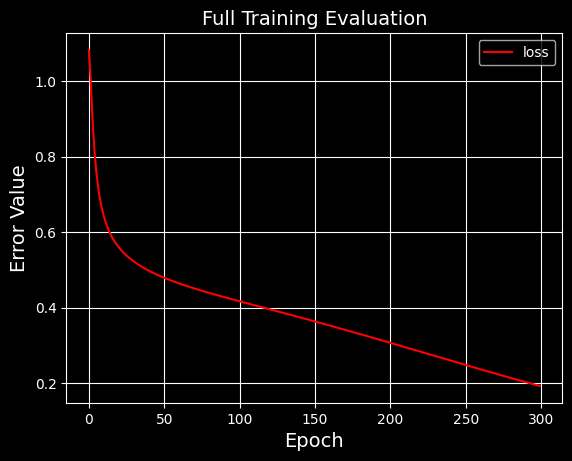

In [17]:
plt.plot(losses_2, label='loss', color='red')
plt.title('Full Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**G. Testing the Network**

In [18]:
model_2 = BalancedNeuralNetwork(5000,3)
state = torch.load("./torch_models/model_2.pth")
model_2.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [19]:
y_test1

tensor([1, 2, 2,  ..., 1, 2, 1])

Using the same `X_test_vec` and `y_test1` we applied on `model_1`.

In [20]:
predictions_2 = model_2.forward(X_test_vec)
predictions_2 = torch.softmax(predictions_2, dim=1)
predictions_2 = torch.argmax(predictions_2, dim=1)
predictions_2

tensor([1, 2, 2,  ..., 1, 2, 1])

In [21]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test1, predictions_2)
accuracy

0.8577755410166079

In [22]:
from sklearn.metrics import recall_score

recall = recall_score(y_test1, predictions_2, average='macro')
recall

0.8566752065941761

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test1, predictions_2))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1550
           1       0.85      0.86      0.86      4451
           2       0.86      0.85      0.85      3934

    accuracy                           0.86      9935
   macro avg       0.87      0.86      0.86      9935
weighted avg       0.86      0.86      0.86      9935



Using its own test set: `X_test` and `y_test2`

In [24]:
predictions_3 = model_2.forward(X_test)
predictions_3 = torch.softmax(predictions_3, dim=1)
predictions_3 = torch.argmax(predictions_3, dim=1)
predictions_3

tensor([0, 0, 2,  ..., 0, 1, 2])

In [28]:
y_test2

tensor([0, 0, 2,  ..., 0, 1, 0])

In [25]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test2, predictions_3)
accuracy

0.6908339295651482

In [26]:
from sklearn.metrics import recall_score

recall = recall_score(y_test2, predictions_3, average='macro')
recall

0.6908136032278062

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, predictions_3))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4193
           1       0.61      0.64      0.62      4452
           2       0.65      0.64      0.65      3934

    accuracy                           0.69     12579
   macro avg       0.70      0.69      0.69     12579
weighted avg       0.69      0.69      0.69     12579



In the end, our `model_2` has an improved performance over `model_1`. Although not shown in the current notebook, at the same 100 epochs of training, model_2 received `74%` on Macro-recall, `74%` on Macro-F1, and `75%` on Accuracy. This results are better than what `model_1` achieved. On the other hand, it got `70%` on all metrics when tested on its own test set, `y_test2`. So it can be concluded that performing resampling on the `Negative` class helped the neural network to learn much better. 

`Model_2` was trained for 300 epochs so that it can have more time to adjust its weights and learn better, until it arrived on its final performance of:

* Macro-Recall = 
* Macro-F1 =
* Accuracy =

Although the model is not improving any better on its own test set even for an additional 200 epochs, it can be concluded that it is still capable of getting right 70% on classifying the correct sentiment of an unseen text, and 30% of the time it will classify it wrong.

#### **End. Thank you!**